# NLP Assignment - News summarization and Identification
## Marco Setiawan
## 0134172
==========================================

## Introduction
News summarization is a method that assist people to summarize news so that user can understand the context easier from the shortened version of the news. On the other hand, news identification is a method that identifies what is the type of news read by users, it can be politics, world, sports, automobile, and so forth. Thus by combining these two functions together, we can have a properly function code that summarizes and identifies the news at the same time.

# Text summarization using LSTM

## Import libraries needed

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import re
import nltk
import string
import keras
import pickle
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from rouge import Rouge
from keras import backend as K
from keras.layers import Layer
from keras.layers import Concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, TimeDistributed, LSTM, Embedding, Input
from keras import Model
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
from sklearn.model_selection import train_test_split
from transformers import pipeline, set_seed
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from nltk.tokenize import sent_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/HP/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

the code below is to set if there is a GPU use the GPU, else use CPU

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [103]:
import os

# Disable parallelism for tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Data preprocessing

the reason we choose news summary is due to our machine inability to use large dataset, thus both of these datasets' size is quite small as compare to other datasets

In [3]:
data = pd.read_csv('/Users/HP/Documents/STUDIES/PYTHONCODES/DATASETS/newsMORE/news_summary.csv', encoding='latin-1')
data_more = pd.read_csv('/Users/HP/Documents/STUDIES/PYTHONCODES/DATASETS/newsMORE/news_summary_more.csv', encoding='latin-1')
data = pd.concat([data, data_more], axis=0).reset_index(drop=True)
data

author                  date  \
0             Chhavi Tyagi  03 Aug 2017,Thursday   
1              Daisy Mowke  03 Aug 2017,Thursday   
2           Arshiya Chopra  03 Aug 2017,Thursday   
3            Sumedha Sehra  03 Aug 2017,Thursday   
4       Aarushi Maheshwari  03 Aug 2017,Thursday   
...                    ...                   ...   
102910                 NaN                   NaN   
102911                 NaN                   NaN   
102912                 NaN                   NaN   
102913                 NaN                   NaN   
102914                 NaN                   NaN   

                                                headlines  \
0       Daman & Diu revokes mandatory Rakshabandhan in...   
1       Malaika slams user who trolled her for 'divorc...   
2       'Virgin' now corrected to 'Unmarried' in IGIMS...   
3       Aaj aapne pakad liya: LeT man Dujana before be...   
4       Hotel staff to get training to spot signs of s...   
...                                                   ...   
102910  CRPF jawan axed to death by Maoists in Chhatti...   
102911  First song from Sonakshi Sinha's 'Noor' titled...   
102912         'The Matrix' film to get a reboot: Reports   
102913  Snoop Dogg aims gun at clown dressed as Trump ...   
102914  Madhesi Morcha withdraws support to Nepalese g...   

                                                read_more  \
0       http://www.hindustantimes.com/india-news/raksh...   
1       http://www.hindustantimes.com/bollywood/malaik...   
2       http://www.hindustantimes.com/patna/bihar-igim...   
3       http://indiatoday.intoday.in/story/abu-dujana-...   
4       http://indiatoday.intoday.in/story/sex-traffic...   
...                                                   ...   
102910                                                NaN   
102911                                                NaN   
102912                                                NaN   
102913                                                NaN   
102914                                                NaN   

                                                     text  \
0       The Administration of Union Territory Daman an...   
1       Malaika Arora slammed an Instagram user who tr...   
2       The Indira Gandhi Institute of Medical Science...   
3       Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4       Hotels in Maharashtra will train their staff t...   
...                                                   ...   
102910  A CRPF jawan was on Tuesday axed to death with...   
102911  'Uff Yeh', the first song from the Sonakshi Si...   
102912  According to reports, a new version of the 199...   
102913  A new music video shows rapper Snoop Dogg aimi...   
102914  Madhesi Morcha, an alliance of seven political...   

                                                    ctext  
0       The Daman and Diu administration on Wednesday ...  
1       From her special numbers to TV?appearances, Bo...  
2       The Indira Gandhi Institute of Medical Science...  
3       Lashkar-e-Taiba's Kashmir commander Abu Dujana...  
4       Hotels in Mumbai and other Indian cities are t...  
...                                                   ...  
102910                                                NaN  
102911                                                NaN  
102912                                                NaN  
102913                                                NaN  
102914                                                NaN  

[102915 rows x 6 columns]

In [4]:
# drop duplication in the data
data.drop_duplicates(subset=['text'],inplace=True)  #dropping duplicates

In [5]:
data

author                  date  \
0             Chhavi Tyagi  03 Aug 2017,Thursday   
1              Daisy Mowke  03 Aug 2017,Thursday   
2           Arshiya Chopra  03 Aug 2017,Thursday   
3            Sumedha Sehra  03 Aug 2017,Thursday   
4       Aarushi Maheshwari  03 Aug 2017,Thursday   
...                    ...                   ...   
102910                 NaN                   NaN   
102911                 NaN                   NaN   
102912                 NaN                   NaN   
102913                 NaN                   NaN   
102914                 NaN                   NaN   

                                                headlines  \
0       Daman & Diu revokes mandatory Rakshabandhan in...   
1       Malaika slams user who trolled her for 'divorc...   
2       'Virgin' now corrected to 'Unmarried' in IGIMS...   
3       Aaj aapne pakad liya: LeT man Dujana before be...   
4       Hotel staff to get training to spot signs of s...   
...                                                   ...   
102910  CRPF jawan axed to death by Maoists in Chhatti...   
102911  First song from Sonakshi Sinha's 'Noor' titled...   
102912         'The Matrix' film to get a reboot: Reports   
102913  Snoop Dogg aims gun at clown dressed as Trump ...   
102914  Madhesi Morcha withdraws support to Nepalese g...   

                                                read_more  \
0       http://www.hindustantimes.com/india-news/raksh...   
1       http://www.hindustantimes.com/bollywood/malaik...   
2       http://www.hindustantimes.com/patna/bihar-igim...   
3       http://indiatoday.intoday.in/story/abu-dujana-...   
4       http://indiatoday.intoday.in/story/sex-traffic...   
...                                                   ...   
102910                                                NaN   
102911                                                NaN   
102912                                                NaN   
102913                                                NaN   
102914                                                NaN   

                                                     text  \
0       The Administration of Union Territory Daman an...   
1       Malaika Arora slammed an Instagram user who tr...   
2       The Indira Gandhi Institute of Medical Science...   
3       Lashkar-e-Taiba's Kashmir commander Abu Dujana...   
4       Hotels in Maharashtra will train their staff t...   
...                                                   ...   
102910  A CRPF jawan was on Tuesday axed to death with...   
102911  'Uff Yeh', the first song from the Sonakshi Si...   
102912  According to reports, a new version of the 199...   
102913  A new music video shows rapper Snoop Dogg aimi...   
102914  Madhesi Morcha, an alliance of seven political...   

                                                    ctext  
0       The Daman and Diu administration on Wednesday ...  
1       From her special numbers to TV?appearances, Bo...  
2       The Indira Gandhi Institute of Medical Science...  
3       Lashkar-e-Taiba's Kashmir commander Abu Dujana...  
4       Hotels in Mumbai and other Indian cities are t...  
...                                                   ...  
102910                                                NaN  
102911                                                NaN  
102912                                                NaN  
102913                                                NaN  
102914                                                NaN  

[100227 rows x 6 columns]

In [6]:
print(data['text'][0])

The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.


### contraction_mapping
contraction mapping is a dictionary that maps commonly used contractions to their expanded forms. In natural language processing (NLP), contractions are shortened versions of words or syllables. For example, "can't" is a contraction of "cannot," and "I've" is a contraction of "I have."

When working with text data, it's common to expand contractions to their full forms as part of the text preprocessing step. This can be beneficial for tasks like text analysis, sentiment analysis, and machine learning, as it helps ensure that words are treated consistently and can improve the accuracy of language models.

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

This is the main preprocessing part that does all stuff needed such as lowercasing, remove special characters, removing double quotes, and so forth so we can have a clean data wo work later on

In [8]:
StopWords = set(stopwords.words('english'))
def preprocess(text):
    new_text = text.lower() #Lowercasing text.
    new_text = re.sub(r'\([^)]*\)', '', new_text) #Removing punctuations and special characters.
    new_text = re.sub('"','', new_text) #Removing double quotes.
    new_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_text.split(" ")]) #Replacing contractions.   
    new_text = re.sub(r"'s\b","",new_text) #Eliminating apostrophe.
    new_text = re.sub("[^a-zA-Z]", " ", new_text) #Removing non-alphabetical characters
    new_text = ' '.join([word for word in new_text.split() if word not in StopWords]) #Removing stopwords.
    new_text = ' '.join([word for word in new_text.split() if len(word) >= 3]) #Removing very short words
    return new_text

#Apply above preprocessing to both text and summary separately.
text_cleaned = []
summ_cleaned = []
for text in data['text']:
    text_cleaned.append(preprocess(text))
for summary in data['headlines']:
    summ_cleaned.append(preprocess(summary))
clean_df = pd.DataFrame()
clean_df['text'] = text_cleaned
clean_df['headline'] = summ_cleaned

#Replacing empty string summaries with nan values and then dropping those datapoints.
clean_df['headline'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

#Adding START and END tokens to summaries for later use.
clean_df['headline'] = clean_df['headline'].apply(lambda x: '<START>' + ' '+ x + ' '+ '<END>')
for i in range(10):
    print('News: ', clean_df['text'][i])
    print('Headline:', clean_df['headline'][i])
    print('\n')

News:  administration union territory daman diu revoked order made compulsory women tie rakhis male colleagues occasion rakshabandhan august administration forced withdraw decision within hours issuing circular received flak employees slammed social media
Headline: <START> daman diu revokes mandatory rakshabandhan offices order <END>


News:  malaika arora slammed instagram user trolled divorcing rich man fun alimony life wearing short clothes going gym salon enjoying vacation user commented malaika responded certainly got get damn facts right spewing know nothing
Headline: <START> malaika slams user trolled divorcing rich man <END>


News:  indira gandhi institute medical sciences patna thursday made corrections marital declaration form changing virgin option unmarried earlier bihar health minister defined virgin unmarried woman consider term objectionable institute however faced strong backlash asking new recruits declare virginity form
Headline: <START> virgin corrected unmarried ig

In [9]:
#Get max length of texts and summaries.
max_len_news = max([len(text.split()) for text in clean_df['text']])
max_len_headline = max([len(text.split()) for text in clean_df['headline']])
print(max_len_news, max_len_headline)

53 14


We split the data using train test split and tokenize both the news (text column) and the headline before we feed it into our LSTM model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(clean_df['text'], clean_df['headline'], test_size=0.2, random_state=0)

#Keras tokenizer for news text.
news_tokenizer = Tokenizer()
news_tokenizer.fit_on_texts(list(X_train))
x_train_seq = news_tokenizer.texts_to_sequences(X_train)
x_test_seq = news_tokenizer.texts_to_sequences(X_test)
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len_news, padding='post') #Post padding short texts with 0s.
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len_news, padding='post')
#Vocab size of texts.
news_vocab = len(news_tokenizer.word_index) + 1

#Keras Tokenizer for summaries.
headline_tokenizer = Tokenizer()
headline_tokenizer.fit_on_texts(list(y_train))
y_train_seq = headline_tokenizer.texts_to_sequences(y_train)
y_test_seq = headline_tokenizer.texts_to_sequences(y_test)
y_train_pad = pad_sequences(y_train_seq, maxlen=max_len_headline, padding='post')
y_test_pad = pad_sequences(y_test_seq, maxlen=max_len_headline, padding='post')
#Vocab size of summaries.
headline_vocab = len(headline_tokenizer.word_index) + 1

# Modelling

## LSTM 
Long Short Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture designed to capture long-term dependencies in sequences. Regular RNNs can struggle with learning and remembering patterns in sequences over long distances, but LSTMs are designed to address this issue. Thus that is the reason we use LSTM in this assignment

In [11]:
#LSTM without attention layer

K.clear_session()

embedding_dim = 300 #Size of word embeddings.
latent_dim = 500 #No. of neurons in LSTM layer.

encoder_input = Input(shape=(max_len_news, ))
encoder_emb = Embedding(news_vocab, embedding_dim, trainable=True)(encoder_input) #Embedding Layer

#Three-stacked LSTM layers for encoder. Return_state returns the activation state vectors, a(t) and c(t), return_sequences return the output of the neurons y(t).
#With layers stacked one above the other, y(t) of previous layer becomes x(t) of next layer.
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_1, a_1, c_1 = encoder_lstm1(encoder_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_2, a_2, c_2 = encoder_lstm2(y_1)

encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output, a_enc_0, c_enc_0 = encoder_lstm3(y_2)

#Single LSTM layer for decoder followed by Dense softmax layer to predict the next word in summary.
decoder_input = Input(shape=(None,))
decoder_emb = Embedding(headline_vocab, embedding_dim, trainable=True)(decoder_input)

decoder_lstm_0 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_output, decoder_fwd, decoder_back = decoder_lstm_0(decoder_emb, initial_state=[a_enc_0, c_enc_0]) #Final output states of encoder last layer are fed into decoder.

decoder_dense_0 = TimeDistributed(Dense(headline_vocab, activation='softmax'))
decoder_output = decoder_dense_0(decoder_output)

model0 = Model([encoder_input, decoder_input], decoder_output)
model0.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 53)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 53, 300)              2082570   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 53, 500),            1602000   ['embedding[0][0]']           
                              (None, 500),                                                        
                              (None, 500)]                                                    

In [12]:
#Training the model with Early Stopping callback on val_loss.
model0.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history=model0.fit([x_train_pad,y_train_pad[:,:-1]], y_train_pad.reshape(y_train_pad.shape[0],y_train_pad.shape[1], 1)[:,1:] ,epochs=15,callbacks=[callback],batch_size=512, validation_data=([x_test_pad,y_test_pad[:,:-1]], y_test_pad.reshape(y_test_pad.shape[0],y_test_pad.shape[1], 1)[:,1:]))

Epoch 1/15
157/157 [==============================] - 1483s 9s/step - loss: 4.9291 - val_loss: 4.4328
Epoch 2/15
157/157 [==============================] - 1486s 9s/step - loss: 4.5191 - val_loss: 4.3582
Epoch 3/15
157/157 [==============================] - 1506s 10s/step - loss: 4.3906 - val_loss: 4.2410
Epoch 4/15
157/157 [==============================] - 1465s 9s/step - loss: 4.2078 - val_loss: 4.0455
Epoch 5/15
157/157 [==============================] - 1495s 10s/step - loss: 3.9863 - val_loss: 3.8690
Epoch 6/15
157/157 [==============================] - 1449s 9s/step - loss: 3.7863 - val_loss: 3.7247
Epoch 7/15
157/157 [==============================] - 1489s 9s/step - loss: 3.6067 - val_loss: 3.6107
Epoch 8/15
157/157 [==============================] - 1500s 10s/step - loss: 3.4432 - val_loss: 3.5137
Epoch 9/15
157/157 [==============================] - 1574s 10s/step - loss: 3.2950 - val_loss: 3.4247
Epoch 10/15
157/157 [==============================] - 1519s 10s/step - loss: 

# Improving the LSTM with Attention Layer
The attention layer in LSTM-based text summarization models is a mechanism that helps the model focus on different parts of the input sequence when generating each element of the output sequence. This is particularly useful in tasks where the input and output sequences are of different lengths, and the model needs to selectively attend to relevant information during the decoding process. Therefore, attention layer can help a neural network in memorizing the large sequences of data.

In [13]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [14]:
#LSTM Model with Attention Layer integrated

K.clear_session()

embedding_dim = 300 #Size of word embeddings.
latent_dim = 500 #No. of neurons in LSTM layer.

encoder_input = Input(shape=(max_len_news, ))
encoder_emb = Embedding(news_vocab, embedding_dim, trainable=True)(encoder_input) #Embedding Layer

#Three-stacked LSTM layers for encoder. Return_state returns the activation state vectors, a(t) and c(t), return_sequences return the output of the neurons y(t).
#With layers stacked one above the other, y(t) of previous layer becomes x(t) of next layer.
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_1, a_1, c_1 = encoder_lstm1(encoder_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
y_2, a_2, c_2 = encoder_lstm2(y_1)

encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_output, a_enc, c_enc = encoder_lstm3(y_2)

#Single LSTM layer for decoder followed by Dense softmax layer to predict the next word in summary.
decoder_input = Input(shape=(None,))
decoder_emb = Embedding(headline_vocab, embedding_dim, trainable=True)(decoder_input)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
decoder_output, decoder_fwd, decoder_back = decoder_lstm(decoder_emb, initial_state=[a_enc, c_enc]) #Final output states of encoder last layer are fed into decoder.

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_output, decoder_output]) 

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_output, attn_out])

decoder_dense = TimeDistributed(Dense(headline_vocab, activation='softmax'))
decoder_output = decoder_dense(decoder_concat_input)

model = Model([encoder_input, decoder_input], decoder_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 53)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 53, 300)              2082570   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 53, 500),            1602000   ['embedding[0][0]']           
                              (None, 500),                                                        
                              (None, 500)]                                                    

In [16]:
#Training the model with Early Stopping callback on val_loss.
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callback = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
history1=model.fit([x_train_pad,y_train_pad[:,:-1]], y_train_pad.reshape(y_train_pad.shape[0],y_train_pad.shape[1], 1)[:,1:] ,epochs=15,callbacks=[callback],batch_size=512, validation_data=([x_test_pad,y_test_pad[:,:-1]], y_test_pad.reshape(y_test_pad.shape[0],y_test_pad.shape[1], 1)[:,1:]))

Epoch 1/15
157/157 [==============================] - 2263s 14s/step - loss: 4.4496 - val_loss: 4.1969
Epoch 2/15
157/157 [==============================] - 2282s 15s/step - loss: 4.1391 - val_loss: 3.9184
Epoch 3/15
157/157 [==============================] - 2237s 14s/step - loss: 3.8340 - val_loss: 3.6791
Epoch 4/15
157/157 [==============================] - 2193s 14s/step - loss: 3.5651 - val_loss: 3.5054
Epoch 5/15
157/157 [==============================] - 2131s 14s/step - loss: 3.3307 - val_loss: 3.3965
Epoch 6/15
157/157 [==============================] - 2160s 14s/step - loss: 3.1300 - val_loss: 3.3053
Epoch 7/15
157/157 [==============================] - 2130s 14s/step - loss: 2.9531 - val_loss: 3.2428
Epoch 8/15
157/157 [==============================] - 2144s 14s/step - loss: 2.7916 - val_loss: 3.2067
Epoch 9/15
157/157 [==============================] - 2147s 14s/step - loss: 2.6394 - val_loss: 3.1782
Epoch 10/15
157/157 [==============================] - 2149s 14s/step - l

## Inference Model
Inference Model is the combination of the trained encoder and decoder used during the prediction phase. It encodes the input sequence and generates the output sequence autonomously.

Encoder: Processes the input sequence, capturing its meaningful information and transforming it into a fixed-size context.

Decoder: Takes the encoded context and generates the output sequence step by step, conditioned on the encoded information.

In essence, the encoder captures input information, the decoder generates the output, and the inference model combines both for autonomous sequence generation during prediction.

In [17]:
#Encoder inference model with trained inputs and outputs.
encoder_model = Model(inputs=encoder_input, outputs=[encoder_output, a_enc, c_enc])

#Initialising state vectors for decoder.
decoder_initial_state_a = Input(shape=(latent_dim,))
decoder_initial_state_c = Input(shape=(latent_dim,))
decoder_hidden_state = Input(shape=(max_len_news, latent_dim))

#Decoder inference model
decoder_out, decoder_a, decoder_c = decoder_lstm(decoder_emb, initial_state=[decoder_initial_state_a, decoder_initial_state_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state, decoder_out])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_out, attn_out_inf])

decoder_final = decoder_dense(decoder_inf_concat)
decoder_model = Model([decoder_input]+[decoder_hidden_state, decoder_initial_state_a, decoder_initial_state_c], [decoder_final]+[decoder_a, decoder_c])

In [18]:
#Function to generate output summaries.
def decoded_sequence(input_seq):
    encoder_out, encoder_a, encoder_c = encoder_model.predict(input_seq) #Collecting output from encoder inference model.
    #Initialise input to decoder neuron with START token. Thereafter output token predicted by each neuron will be used as input for the subsequent.
    #Single elt matrix used for maintaining dimensions.
    next_input = np.zeros((1,1))
    next_input[0,0] = headline_tokenizer.word_index['start']
    output_seq = ''
    #Stopping condition to terminate loop when one summary is generated.
    stop = False
    while not stop:
        #Output from decoder inference model, with output states of encoder used for initialisation.
        decoded_out, trans_state_a, trans_state_c = decoder_model.predict([next_input] + [encoder_out, encoder_a, encoder_c])
        #Get index of output token from y(t) of decoder.
        output_idx = np.argmax(decoded_out[0, -1, :])
        #If output index corresponds to END token, summary is terminated without of course adding the END token itself.
        if output_idx == headline_tokenizer.word_index['end']: 
            stop = True
        elif output_idx>0 and output_idx != headline_tokenizer.word_index['start'] :
            output_token = headline_tokenizer.index_word[output_idx] #Generate the token from index.
            output_seq = output_seq + ' ' + output_token #Append to summary
        
        #Pass the current output index as input to next neuron.
        next_input[0,0] = output_idx
        #Continously update the transient state vectors in decoder.
        encoder_a, encoder_c = trans_state_a, trans_state_c
        
    return output_seq 

#Print predicted summmaries and actual summaries for 10 texts. 
#We see that some of the summaries go a bit off topic, but the domain concerned, eg. politics, cricket, etc. remains largely same. 
#Further improvements can be done with Attention mechanisms, where each subsequent word generated in the summary receives different weightage
#from earlier generated words.
predicted = []
for i in range(15):
    print('News:', X_test.iloc[i])
    print('Actual Headline:', y_test.iloc[i])
    print('Predicted Headline:', decoded_sequence(x_test_pad[i].reshape(1, max_len_news)))
    predicted.append(decoded_sequence(x_test_pad[i].reshape(1, max_len_news)).split())

News: world number serena williams defeated world number anastasija sevastova thursday enter ninth open final years maiden flushing meadows final serena played grand slam finals till winning year old american face year old japan naomi osaka final saturday
Actual Headline: <START> serena enters open final yrs first <END>
1/1 [==============================] - 0s 12ms/step
Predicted Headline:  world champ beats french open final final
1/1 [==============================] - 0s 14ms/step
News: according reports commerce major flipkart looking buy competitor snapdeal million comes reports may suggested flipkart offered buy snapdeal billion stock deal million figure near discount snapdeal billion valuation last raised money
Actual Headline: <START> flipkart might buy snapdeal report <END>
1/1 [==============================] - 0s 12ms/step
Predicted Headline:  flipkart group may buy flipkart stake report
1/1 [==============================] - 0s 12ms/step
News: talking working alia bhatt raa

1/1 [==============================] - 0s 14ms/step
News: england women cricket team player danielle wyatt called afghanistan rounder rashid khan slogerrrrrrr latter scored ball afghanistan premier league rashid captaining kabul zwanan side tournament hit three fours five sixes innings rashid also hit ravi bopara runs
Actual Headline: <START> wyatt calls rashid slogerrrrrrr ball <END>
1/1 [==============================] - 0s 12ms/step
Predicted Headline:  england bowler slams kohli ipl runs
1/1 [==============================] - 0s 14ms/step
News: google ceo sundar pichai received compensation package million parent firm alphabet first year helm company pichai received salary besides million stock award roughly double stock pichai paid million half current compensation
Actual Headline: <START> google ceo pichai paid compensation <END>
1/1 [==============================] - 0s 13ms/step
Predicted Headline:  google ceo pichai earned crore per day
1/1 [==============================] - 0

1/1 [==============================] - 0s 14ms/step
Predicted Headline:  jnu students learn haryana varsity exam
1/1 [==============================] - 0s 13ms/step
News: japanese conglomerate softbank vision fund reportedly planning raise billion debt help finance acquisitions hired financial service companies goldman sachs mizuho work deal launched fund investments include ride hailing startup uber shared office space provider wework
Actual Headline: <START> softbank vision fund plans raise debt report <END>
1/1 [==============================] - 0s 13ms/step
Predicted Headline:  softbank may raise billion buy india report
1/1 [==============================] - 0s 13ms/step


In [19]:
# Displays the actual references and predicted summarizations
summaries = list(y_test)
references = []
for summ in summaries:
    ref = summ.split()
    ref.remove('<START>')
    ref.remove('<END>')
    references.append(ref)

## BLEU - Model Evaluation method

BLEU (Bilingual Evaluation Understudy) is a metric assessing the quality of machine-generated text, commonly used in machine translation. It measures how closely the generated text matches one or more reference translations. The score ranges from 0 to 1, with 1 indicating a perfect match. BLEU considers precision of n-grams, addresses brevity, and computes modified n-gram precision. While widely used, BLEU has limitations and may not fully capture the quality of generated text, particularly in creative language tasks.

In [20]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

refs = []
smooth = SmoothingFunction().method4

for i in range(14):
    refs.append(references[i])
    print("References:", refs)
    print("Predicted:", predicted[i])
    print('')
    print("BLEU Score:", sentence_bleu(refs, predicted[i], weights=(0.25, 0.25, 0.25, 0.25)))
    print('========================================')
    print('')
    refs.remove(references[i])


References: [['serena', 'enters', 'open', 'final', 'yrs', 'first']]
Predicted: ['world', 'champ', 'beats', 'french', 'open', 'final', 'final']

BLEU Score: 6.968148412761692e-155

References: [['flipkart', 'might', 'buy', 'snapdeal', 'report']]
Predicted: ['flipkart', 'group', 'may', 'buy', 'flipkart', 'stake', 'report']

BLEU Score: 1.4740564900137075e-231

References: [['alia', 'take', 'star', 'granted', 'vicky', 'kaushal']]
Predicted: ['alia', 'bhatt', 'never', 'successful', 'career', 'raazi']

BLEU Score: 1.1640469867513693e-231

References: [['amazon', 'fashion', 'week', 'begins', 'show', 'handloom', 'fabrics']]
Predicted: ['amazon', 'presents', 'diwali', 'diwali']

BLEU Score: 6.085166479973199e-232

References: [['exploring', 'legal', 'angles', 'renaming', 'ahmedabad', 'karnavati']]
Predicted: ['gujarat', 'govt', 'announces', 'retirement', 'income', 'state']

BLEU Score: 0

References: [['nasa', 'new', 'horizons', 'probe', 'navigated', 'mumbai', 'born', 'scientist']]
Predicted: 

/Users/HP/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/HP/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/HP/anaconda3/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingF

In [21]:
# Provide input text and try to predict the summarized text using the LSTM model
input_text = """A lion that escaped from a circus in the Italian town of Ladispoli, near Rome, on Saturday has been recaptured after several hours on the loose, the local mayor has announced.

Just after 10 p.m. local time (5 p.m. ET) on Saturday, Ladispoli mayor Alessandro Grando announced on his Facebook page that the lion had been caught.

The animal had been on the loose for at least 5 hours, causing concern and confusion among local residents.

“The lion has been sedated and captured. It will now be handed over by the circus staff. I thank the State Police, the Carabinieri, the Fire Department, the local and provincial police, the Asl [Local Health Authority], and all the volunteers who served during these hours of great apprehension,” Grando said on social media on Saturday evening.

“I hope that this episode will stir some consciences, and that we can finally put an end to the exploitation of animals in circuses,” he added."""

# Tokenize and pad the input text
input_sequence = news_tokenizer.texts_to_sequences([input_text])
input_sequence_padded = pad_sequences(input_sequence, maxlen=max_len_news, padding='post')

# Use the trained models to generate a summary
predicted_summary = decoded_sequence(input_sequence_padded)

# Print the result
print('Input Text:', input_text)
print(" ")
print('Predicted Summary:', predicted_summary)


1/1 [==============================] - 0s 13ms/step
Input Text: A lion that escaped from a circus in the Italian town of Ladispoli, near Rome, on Saturday has been recaptured after several hours on the loose, the local mayor has announced.

Just after 10 p.m. local time (5 p.m. ET) on Saturday, Ladispoli mayor Alessandro Grando announced on his Facebook page that the lion had been caught.

The animal had been on the loose for at least 5 hours, causing concern and confusion among local residents.

“The lion has been sedated and captured. It will now be handed over by the circus staff. I thank the State Police, the Carabinieri, the Fire Department, the local and provincial police, the Asl [Local Health Authority], and all the volunteers who served during these hours of great apprehension,” Grando said on social media on Saturday evening.

“I hope that this episode will stir some consciences, and that we can finally put an end to the exploitation of animals in circuses,” he added.
 
Predi

In [22]:
#Save model for deployment later
model.save('model.h5')

/Users/HP/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
#Save tokenizers for deployment purpose
with open('news_tokenizer.pkl', 'wb') as f:
    pickle.dump(news_tokenizer, f)

with open('headline_tokenizer.pkl', 'wb') as f:
    pickle.dump(headline_tokenizer, f)

# Text Summarization using fine-tuned PEGASUS

The SummarizationDataset is a custom dataset class designed for training text summarization models. It is tailored for use with PyTorch and encapsulates the necessary functionalities for handling input articles and their corresponding summaries. The dataset takes a DataFrame containing "article" and "highlights" columns, and each data instance is processed to obtain tokenized input and output sequences. The dataset includes provisions for tokenization, padding, and attention mask creation, preparing the data for training summarization models using PyTorch's DataLoader.

In [24]:
class SummarizationDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length=512, max_output_length=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        article = self.data.iloc[index]["article"]
        summary = self.data.iloc[index]["highlights"]
        input_ids = self.tokenizer.encode(article, max_length=self.max_input_length, truncation=True, padding="max_length")
        output_ids = self.tokenizer.encode(summary, max_length=self.max_output_length, truncation=True, padding="max_length")
        return {"input_ids": input_ids, "attention_mask": [int(token_id != 0) for token_id in input_ids], "decoder_input_ids": output_ids[:-1], "decoder_attention_mask": [1] * (len(output_ids) - 1), "labels": output_ids[1:]}

## Data preprocessing

In [25]:
# Import train, test, and validation data
train_df = pd.read_csv("/Users/HP/Documents/STUDIES/PYTHONCODES/DATASETS/cnn_dailymail/train.csv")
test_df = pd.read_csv("/Users/HP/Documents/STUDIES/PYTHONCODES/DATASETS/cnn_dailymail/test.csv")
val_df = pd.read_csv("/Users/HP/Documents/STUDIES/PYTHONCODES/DATASETS/cnn_dailymail/validation.csv")

In [26]:
# Define the initialized the PEGASUS model and tokenization technique
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# This is where it use the function above to do preprocessing and tokenization
train_dataset = SummarizationDataset(train_df, tokenizer)
val_dataset = SummarizationDataset(val_df, tokenizer)

The custom collate function is designed for handling batch processing in a PyTorch DataLoader during the training or evaluation of a text summarization model. It pads variable-length input and output sequences within a batch with zeros to match the maximum sequence lengths. The function then creates PyTorch tensors for the input and output sequences, attention masks, and labels, returning them as a dictionary for efficient batch processing.

In [28]:
def collate_fn(batch):
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    decoder_input_ids = [item["decoder_input_ids"] for item in batch]
    decoder_attention_mask = [item["decoder_attention_mask"] for item in batch]
    labels = [item["labels"] for item in batch]
    max_input_length = max(len(ids) for ids in input_ids)
    max_output_length = max(len(ids) for ids in decoder_input_ids)
    input_ids = [ids + [0] * (max_input_length - len(ids)) for ids in input_ids]
    attention_mask = [mask + [0] * (max_input_length - len(mask)) for mask in attention_mask]
    decoder_input_ids = [ids + [0] * (max_output_length - len(ids)) for ids in decoder_input_ids]
    decoder_attention_mask = [mask + [0] * (max_output_length - len(mask)) for mask in decoder_attention_mask]
    labels = [ids + [-100] * (max_output_length - len(ids)) for ids in labels]
    return {"input_ids": torch.tensor(input_ids), "attention_mask": torch.tensor(attention_mask), "decoder_input_ids": torch.tensor(decoder_input_ids), "decoder_attention_mask": torch.tensor(decoder_attention_mask), "labels": torch.tensor(labels)}

A DataLoader in PyTorch is a utility that provides an iterable over a dataset. It loads and manages batches of data, handles shuffling, and can perform other custom processing using a collate function. DataLoaders are commonly used in machine learning workflows for efficient batch processing during training and evaluation.

In [29]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2,collate_fn=collate_fn)

In [30]:
#AdamW is a type of opitimizer that is use to set the learning rate of the model
optimizer = AdamW(model.parameters(), lr=5e-5)

# scheduler is used to adjust learning rate during training
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=10000)

/Users/HP/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [31]:
len(train_loader),len(val_loader)

(143557, 6684)

## PEGASUS Model
we did hyperparameter tuning for the model and found out that currently, the best training steps is 500

In [32]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()
for epoch in range(10):
    train_loss = 0
    for step,batch in tqdm(enumerate(train_loader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        loss = model(**batch).loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        if step%500==0 and step>0:
            print("Step-{},Train Loss-{}".format(step,loss.item()))
            break#intentionally breaking the training after 100 steps since it's going to take long to train,feel free to comment and train more
        train_loss += loss.item()
    train_loss /= len(train_loader)
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for step,batch in tqdm(enumerate(val_loader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            loss = model(**batch).loss
            val_loss += loss.item()
            if step%100==0 and step>0:
                print("Step-{},Val Loss-{}".format(step,loss.item()))
                break #intentionally breaking the training after 100 steps since it's going to take long to validate,feel free to comment and validate more
        val_loss /= len(val_loader)
    model.train()
    break # when you train more then uncomment this, too !
    print(f"Epoch {epoch+1} train loss: {train_loss:.4f} val loss: {val_loss:.4f}")

500it [1:14:49,  8.98s/it]


Step-500,Train Loss-5.021738052368164


100it [02:15,  1.35s/it]

Step-100,Val Loss-5.617832660675049


In [33]:
# Save the model for training
model.save_pretrained("fine_tuned_pegasus")
tokenizer.save_pretrained("fine_tuned_pegasus")

('fine_tuned_pegasus/tokenizer_config.json',
 'fine_tuned_pegasus/special_tokens_map.json',
 'fine_tuned_pegasus/spiece.model',
 'fine_tuned_pegasus/added_tokens.json')

In [34]:
# Preprocessing the test set
test_dataset = SummarizationDataset(test_df, tokenizer)

In [35]:
# Load test dataset to data loader
test_loader = DataLoader(test_dataset, batch_size=1,collate_fn=collate_fn)

In [36]:
len(test_loader)

11490

In [37]:
# Prediction on the text dataset
model.to(device)
model.eval()
predictions = []
with torch.no_grad():
    for step, batch in tqdm(enumerate(test_loader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        output_ids = model.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], max_length=128, decoder_start_token_id=tokenizer.pad_token_id)
        batch_predictions = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output_ids]
        predictions.extend(batch_predictions)
        if step==100:
            break # breaking after generating 100 predictions.. since it's going to take long to predict on entire set

100it [17:16, 10.36s/it]


In [38]:
# Save the predictions to a CSV file
test_df = test_df[:101]# for 100 predicitons only
print(len(test_df))
test_df["predictions"] = predictions
test_df.to_csv("test_predictions.csv", index=False)

101


/var/folders/7v/krfvgn7d7xg1m339zmy3gh940000gn/T/ipykernel_1017/959527322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predictions"] = predictions


## Evaluation metrics
we use rouge to evaluate the performance of the PEGASUS model and the definition will be explain later in below

In [39]:
from rouge_score import rouge_scorer

# Create a RougeScorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

# Initialize scores dictionary
scores = {key: 0.0 for key in ['rouge1', 'rouge2', 'rougeL']}

# Iterate through each row in the DataFrame
for index, row in test_df.iterrows():
    actual_summary = row['highlights']
    predicted_summary = row['predictions']

    # Calculate ROUGE scores
    temp_scores = scorer.score(actual_summary, predicted_summary)

    # Add the scores to the running total
    for key in temp_scores:
        scores[key] += temp_scores[key].fmeasure  # Extract the fmeasure value

# Calculate average scores
num_samples = len(test_df)
average_scores = {key: score / num_samples for key, score in scores.items()}

# Print average scores
for key in average_scores:
    print(f'Average {key} score: {average_scores[key]}')


Average rouge1 score: 0.2835290016929451
Average rouge2 score: 0.10389993658141611
Average rougeL score: 0.19598930206840126


In [40]:
# Load the model and tokenizer
model = PegasusForConditionalGeneration.from_pretrained("fine_tuned_pegasus")
tokenizer = PegasusTokenizer.from_pretrained("fine_tuned_pegasus")

# Set the device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

# Define the input text for prediction
input_text = "Do they Colorado Buffaloes play this weekend? If you're like us, that's the first thing you think about with each new week of the 2023 NCAA college football season. The 4-3 Buffaloes, led by NFL and MLB great Deion 'Coach Prime' Sanders, are the biggest thing to hit college football this year.Coach Prime's Buffaloes, led by Sander's stellar quarterback and son Shadeur Sanders, came into the 2023 college football season with a shocking upset win over TCU. Ever since then, the Buffaloes and Coach Prime have been ruffling feathers, winning games and turning one football fan after the next into Colorado Buffaloes fans.Keep reading for how and when to watch the next Colorado Buffaloes next game.Do the Colorado Buffaloes play this weekend?The Buffaloes have a bye week this week, which gives them plenty of time to recover from that ugly Week 7 loss to the Stanford Cardinals. The Buffaloes return to face off against the UCLA Bruins on Saturday, Oct. 28 at 7:30 p.m. ET (4:30 p.m. PT). The game will be broadcast on ABC.Next weekend's game will be held at the Rose Bowl in Pasadena, CA. The game is completely sold out, with as many as 67,000 people expected to attend live."

# Tokenize the input text
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

# Generate predictions for the input text
with torch.no_grad():
    output = model.generate(input_ids, max_length=200, num_return_sequences=1, no_repeat_ngram_size=2)

# Decode the output tokens to get the predicted text
predicted_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Print the predicted text
print(predicted_text)

how and when to watch the next Colorado Buffaloes next game.


# Text summarization using BART, T5, and PEGASUS

Library used is combine at the very above of the code.

The reason we choose CNN_dailymail news for these models is due to the diversity of the contents and its size, thus each time when we run the model with different text, we can see the performance of these model. Moreover, these models are not using the dataset to train since all of them are pre-trained, so we only use the dataset as an input to check their performance.

In [41]:
# Import dataset
df = pd.read_csv('/Users/HP/Documents/STUDIES/PYTHONCODES/DATASETS/cnn_dailymail/train.csv')

In [42]:
# This code is for displaying the first row of the article and summary content
print(f"""
Article (excerpt of 500 characters, total length: {len(df["article"][0])}):
""")
print(df["article"][0][:500])
print(f'\nSummary (length: {len(df["highlights"][0])}):')
print(df["highlights"][0])


Article (excerpt of 500 characters, total length: 1211):

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in N

Summary (length: 220):
Bishop John Folda, of North Dakota, is taking time off after being diagnosed .
He contracted the infection through contaminated food in Italy .
Church members in Fargo, Grand Forks and Jamestown could have been exposed .


In [43]:
# second row in article column is chosen for later use
sample_text = df["article"][1][:1000]

# We'll collect the generated summaries of each model in a dictionary
summaries = {}

## Comparing several Text summarization Models

### T5

T5, or Text-To-Text Transfer Transformer, is a versatile language model by Google that addresses various NLP tasks by framing them as text generation problems. Unlike task-specific models, T5 uses a unified text format for both input and output, making it adaptable to different applications. Built on the transformer architecture, T5 employs self-attention mechanisms for effective language understanding and has been pre-trained on extensive data. It can be fine-tuned for specific tasks, making it widely used in natural language processing. Thus these are the reasons we usse T5 to see how it works on the sample text

pipeline is used for declaring and initializing the model and we need to put "summarization" so that it knows we want to do is summarization

In [44]:
pipe = pipeline('summarization', model='t5-small')

pipe_out= pipe(sample_text)

In [45]:
pipe_out

[{'summary_text': 'a criminal complaint accuses the 45-year-old of using his role as a police officer . he worked with a drug trafficking organization to plan a murder plot and get guns . the complaint alleges that he arranged to pay two assassins to kill rival drug dealers .'}]

In [46]:
summaries['t5'] = 'n'.join(sent_tokenize(pipe_out[0]['summary_text']))

### BART

BART (Bidirectional and Auto-Regressive Transformers) is a neural network-based model designed for natural language processing (NLP) tasks. It excels in text generation and summarization by employing both auto-regressive and bidirectional architectures. BART is pre-trained on large text corpora and can be fine-tuned for various tasks like text summarization, translation, and more. Therefore, one reason for using it in this assignment is its ability to generate coherent and contextually relevant summaries by considering the entire input text bidirectionally. Additionally, BART's auto-regressive nature allows it to generate output sequentially, making it effective for tasks like abstractive summarization. The model's versatility and strong performance in diverse NLP applications contribute to its popularity.

In [47]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)

In [48]:
pipe_out

[{'summary_text': 'Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department. Authorities allege that the 45-year-old longtime officer worked with a drug trafficking organization. A criminal complaint unsealed in U.S. District Court in New Jersey accuses Mata of using his role as a police officer.'}]

In [49]:
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [50]:
summaries["bart"]

'Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department.\nAuthorities allege that the 45-year-old longtime officer worked with a drug trafficking organization.\nA criminal complaint unsealed in U.S. District Court in New Jersey accuses Mata of using his role as a police officer.'

### PEGASUS

PEGASUS, a transformer-based model for abstractive text summarization, introduces gap sentences during training to focus on key content. Using a denoising autoencoder objective, it aims for abstractiveness, generating coherent summaries. With transfer learning support, PEGASUS adapts to various tasks and domains, showcasing robust performance in abstractive summarization. Hence, those are the reasons we used PEGASUS also in this part of the assignment

In [51]:
pipe = pipeline('summarization', model="google/pegasus-cnn_dailymail"  )

pipe_out = pipe(sample_text, max_length=100)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
pipe_out

[{'summary_text': 'Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department .<n>Authorities allege he worked with a drug trafficking organization to help plan a murder plot .<n>In one instance, the complaint alleges, Mata arranged to pay two assassins to kill rival drug dealers .'}]

In [53]:
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

### Comparison results between Models

In [54]:
# we use this code to display the actual news and the predicted summaries
print("GROUND TRUTH")

print(df['article'][1])
print(" ")

for model_name in summaries:
    print(model_name.upper())
    print(' ')
    print(summaries[model_name])
    print("====================================")
    print(' ')

GROUND TRUTH
(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, authorities allege that the 45-year-old longtime officer worked with a drug trafficking organization to help plan a murder plot and get guns. A criminal complaint unsealed in U.S. District Court in New Jersey Tuesday accuses Mata, also known as "The Milk Man," of using his role as a police officer to help the drug trafficking organization in exchange for money and gifts, including a Rolex watch. In one instance, the complaint alleges, Mata arranged to pay two assassins to kill rival drug dealers. The killers would pose as cops, pulling over their targets before shooting them, according to the complaint. "Ultimately, the (organization) decided not to move forward with the murder plot, but Mata still received a payment for setting up the meetings," federal prosecutors said in a statement.

## Evaluation Methods

### BLEU

In [55]:
# Same as above we use BLEU as our evaluation method
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

/var/folders/7v/krfvgn7d7xg1m339zmy3gh940000gn/T/ipykernel_1017/3923773917.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [56]:
bleu_metric.add(prediction = [summaries["pegasus"]], reference = [df['highlights'][1]])

results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0 )

results['precision'] = [np.round(p , 2) for p in results['precisions'] ]

pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'] )

Value
score                                               15.650833
counts                                         [23, 11, 6, 3]
totals                                       [54, 53, 52, 51]
precisions  [42.592592592592595, 20.754716981132077, 11.53...
bp                                                        1.0
sys_len                                                    54
ref_len                                                    42
precision                         [42.59, 20.75, 11.54, 5.88]

### Rouge

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a metric used to evaluate the quality of summaries by comparing them to reference or model-generated summaries. It measures the overlap between n-grams (contiguous sequences of n items, usually words) in the generated summary and the reference summaries. ROUGE has various variants, such as ROUGE-N (measuring overlap at the unigram, bigram, trigram, etc., levels), ROUGE-L (computing the longest common subsequence), and ROUGE-W (weighing overlapping words).

In summary, ROUGE is a set of metrics commonly used in natural language processing and text summarization to assess the effectiveness of generated summaries by comparing them to reference summaries.

In [57]:
rouge_metric = load_metric('rouge')

In [58]:
# So here we compare the summaries generated from each model to the actual summary can count the ROUGE score for each model.
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

reference = df['highlights'][1]

records = []

for model_name in summaries:
    rouge_metric.add(prediction = summaries[model_name], reference = reference )
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
    print('rouge_dict ', rouge_dict )
    records.append(rouge_dict)

pd.DataFrame.from_records(records, index = summaries.keys() )


rouge_dict  {'rouge1': 0.46913580246913583, 'rouge2': 0.25316455696202533, 'rougeL': 0.32098765432098764, 'rougeLsum': 0.32098765432098764}
rouge_dict  {'rouge1': 0.30588235294117644, 'rouge2': 0.14457831325301204, 'rougeL': 0.2117647058823529, 'rougeLsum': 0.2823529411764706}
rouge_dict  {'rouge1': 0.5249999999999999, 'rouge2': 0.30769230769230765, 'rougeL': 0.325, 'rougeLsum': 0.45}


rouge1    rouge2    rougeL  rougeLsum
t5       0.469136  0.253165  0.320988   0.320988
bart     0.305882  0.144578  0.211765   0.282353
pegasus  0.525000  0.307692  0.325000   0.450000

# News Identification

## libraries Needed

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to /Users/HP/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/HP/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/HP/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Preprocessing

The reason why we choose this dataset is due to the contents inside consist of a variety of news type such as world , politics, wellness, parenting, and many more, which is suitable for News Identification. Moreover, we also combine other dataset which is similar to this one just to increase the amount of data for a better accuracy for the Model

In [60]:
# Import dataset
df1 = pd.read_csv('/Users/HP/Documents/STUDIES/PYTHONCODES/DATASETS/NewsCategorizer.csv') 

In [61]:
df1

category                                           headline  \
0      WELLNESS              143 Miles in 35 Days: Lessons Learned   
1      WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2      WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3      WELLNESS                     Oh, What a Difference She Made   
4      WELLNESS                                   Green Superfoods   
...         ...                                                ...   
49995    SPORTS  This Baseball Team Learned There's A Wrong Way...   
49996    SPORTS  Some Young Spurs Fan Dabbed 38 Times In A Sing...   
49997    SPORTS  Rasheed Wallace Ejected From Knicks-Suns Game ...   
49998    SPORTS  Why Jake Plummer And Other NFL Players Are Pus...   
49999    SPORTS  Simone Biles Isn't The Next Anyone, She's 'The...   

                                                   links  \
0      https://www.huffingtonpost.com/entry/running-l...   
1      https://www.huffingtonpost.com/entry/talking-t...   
2      https://www.huffingtonpost.com/entry/crenezuma...   
3      https://www.huffingtonpost.com/entry/meaningfu...   
4      https://www.huffingtonpost.com/entry/green-sup...   
...                                                  ...   
49995  https://www.huffingtonpost.com/entry/san-jose-...   
49996  https://www.huffingtonpost.com/entry/dab-kid-s...   
49997  https://www.huffingtonpost.com/entry/rasheed-w...   
49998  https://www.huffingtonpost.comhttp://extras.de...   
49999  https://www.huffingtonpost.com/entry/the-first...   

                                       short_description  \
0      Resting is part of training. I've confirmed wh...   
1      Think of talking to yourself as a tool to coac...   
2      The clock is ticking for the United States to ...   
3      If you want to be busy, keep trying to be perf...   
4      First, the bad news: Soda bread, corned beef a...   
...                                                  ...   
49995  Many fans were pissed after seeing the minor l...   
49996             Never change, young man. Never change.   
49997  Wallace was hit with a first technical for a h...   
49998  They believe CBD could be an alternative to po...   
49999             The gymnast is in a league of her own.   

                                                keywords  
0                                        running-lessons  
1                              talking-to-yourself-crazy  
2                     crenezumab-alzheimers-disease-drug  
3                                        meaningful-life  
4                                       green-superfoods  
...                                                  ...  
49995            san-jose-giants-japanese-heritage-night  
49996                          dab-kid-san-antonio-spurs  
49997  rasheed-wallace-ejected-knicks-suns-ball-dont-lie  
49998                                                NaN  
49999                             the-first-simone-biles  

[50000 rows x 5 columns]

In [62]:
# Check data information
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


In [63]:
# Dropping unecessary columns
df1 = df1.drop(columns=['headline', 'links', 'keywords'])

In [64]:
# copy short_description column data to description column for unison with other dataset later on
df1['description'] = df1['short_description']

# Drop short_description column
df1 = df1.drop(columns=['short_description'])

In [65]:
df1

category                                        description
0      WELLNESS  Resting is part of training. I've confirmed wh...
1      WELLNESS  Think of talking to yourself as a tool to coac...
2      WELLNESS  The clock is ticking for the United States to ...
3      WELLNESS  If you want to be busy, keep trying to be perf...
4      WELLNESS  First, the bad news: Soda bread, corned beef a...
...         ...                                                ...
49995    SPORTS  Many fans were pissed after seeing the minor l...
49996    SPORTS             Never change, young man. Never change.
49997    SPORTS  Wallace was hit with a first technical for a h...
49998    SPORTS  They believe CBD could be an alternative to po...
49999    SPORTS             The gymnast is in a league of her own.

[50000 rows x 2 columns]

In [66]:
#Import another dataset
df2 = pd.read_csv('/Users/HP/Documents/STUDIES/PYTHONCODES/DATASETS/news_category1.csv')

In [67]:
# Combine both dataset together
final_df = pd.concat([df1, df2])

In [68]:
final_df

category                                        description
0      WELLNESS  Resting is part of training. I've confirmed wh...
1      WELLNESS  Think of talking to yourself as a tool to coac...
2      WELLNESS  The clock is ticking for the United States to ...
3      WELLNESS  If you want to be busy, keep trying to be perf...
4      WELLNESS  First, the bad news: Soda bread, corned beef a...
...         ...                                                ...
12115   SCIENCE  Two Indian Air Force doctors who have speciali...
12116   SCIENCE  NASA's Juno space probe has discovered an FM s...
12117   SCIENCE  University of Konstanz's researchers have unco...
12118   SCIENCE  Renowned astrophysicist Professor Shashikumar ...
12119   SCIENCE  Scientists have found two dwarf giraffes in Na...

[62120 rows x 2 columns]

In [69]:
# Dropping data duplication
final_df.drop_duplicates()

category                                        description
0           WELLNESS  Resting is part of training. I've confirmed wh...
1           WELLNESS  Think of talking to yourself as a tool to coac...
2           WELLNESS  The clock is ticking for the United States to ...
3           WELLNESS  If you want to be busy, keep trying to be perf...
4           WELLNESS  First, the bad news: Soda bread, corned beef a...
...              ...                                                ...
12068  ENTERTAINMENT  Katrina Kaif's sister, actress Isabelle Kaif, ...
12069  ENTERTAINMENT  Ayushmann Khurrana took to his Instagram handl...
12073     AUTOMOBILE  Volkswagen CEO Herbert Diess joined Twitter an...
12091     AUTOMOBILE  Tesla is in talks with the Gujarat government ...
12097        SCIENCE  Oxford scientists are preparing to produce new...

[51165 rows x 2 columns]

In [70]:
final_df['category'].value_counts()

category
ENTERTAINMENT     7036
SPORTS            6900
POLITICS          6596
WELLNESS          5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
WORLD NEWS        5000
BUSINESS          5000
WORLD             2067
TECHNOLOGY        1791
SCIENCE           1437
AUTOMOBILE        1293
Name: count, dtype: int64

This process below needs to be done because the rows with index 1 are both technology and wellness so we need to reset the index so that each rows has their own index numbers so index number 1 should just be technology and so forth

In [71]:
# Access rows based on the original integer-based index
print(final_df.loc[1]['category'])  # Accessing the first row with index 1

# Reset the index of your DataFrame
final_df.reset_index(drop=True, inplace=True)


1      WELLNESS
1    TECHNOLOGY
Name: category, dtype: object


In [72]:
# Replace 'WORLD NEWS' with 'WORLD' in the 'category' column since both are actually the same
final_df['category'] = final_df['category'].replace('WORLD NEWS', 'WORLD')

# Verify the updated category counts
category_counts = final_df['category'].value_counts()
print(category_counts)

category
WORLD             7067
ENTERTAINMENT     7036
SPORTS            6900
POLITICS          6596
WELLNESS          5000
TRAVEL            5000
STYLE & BEAUTY    5000
PARENTING         5000
FOOD & DRINK      5000
BUSINESS          5000
TECHNOLOGY        1791
SCIENCE           1437
AUTOMOBILE        1293
Name: count, dtype: int64


In [73]:
# we create anothe dataset which is called as selected_data that contain 1000 rows for each categories

target_rows_per_category = 1000

selected_data = pd.DataFrame(columns=['category'])


In [74]:
#Iterate over each category and select the desired number of rows
for category, count in final_df['category'].value_counts().items():
    if count >= target_rows_per_category:
        # Select the first 2000 rows for the category
        category_data = final_df[final_df['category'] == category].head(target_rows_per_category)
        selected_data = pd.concat([selected_data, category_data])

In [75]:
selected_data['category'].value_counts()

category
WORLD             1000
ENTERTAINMENT     1000
SPORTS            1000
POLITICS          1000
WELLNESS          1000
TRAVEL            1000
STYLE & BEAUTY    1000
PARENTING         1000
FOOD & DRINK      1000
BUSINESS          1000
TECHNOLOGY        1000
SCIENCE           1000
AUTOMOBILE        1000
Name: count, dtype: int64

In [76]:
# reset the index due do duplication of index in every two rows
selected_data.reset_index(drop=True, inplace=True)

In [77]:
# We map each categories with their corresponding numbers for later use in modelling
category_mapping = {
    'SPORTS': 1,
    'BUSINESS': 2,
    'WELLNESS': 3,
    'POLITICS': 4,
    'ENTERTAINMENT': 5,
    'TRAVEL': 6,
    'STYLE & BEAUTY': 7,
    'PARENTING': 8,
    'FOOD & DRINK': 9,
    'WORLD': 10,
    'TECHNOLOGY': 11,
    'SCIENCE': 12,
    'AUTOMOBILE': 13,
}

# Create a new "category_id" column based on the mapping
selected_data['category_id'] = selected_data['category'].map(category_mapping)

# Sort the DataFrame by the "category_id" column
selected_data = selected_data.sort_values(by='category_id')

In [78]:
# We map each categories with their corresponding numbers for later use in modelling
category_mapping = {
    'SPORTS': 1,
    'BUSINESS': 2,
    'WELLNESS': 3,
    'POLITICS': 4,
    'ENTERTAINMENT': 5,
    'TRAVEL': 6,
    'STYLE & BEAUTY': 7,
    'PARENTING': 8,
    'FOOD & DRINK': 9,
    'WORLD': 10,
    'TECHNOLOGY': 11,
    'SCIENCE': 12,
    'AUTOMOBILE': 13,
}

# Create a new "category_id" column based on the mapping
final_df['category_id'] = final_df['category'].map(category_mapping)

# Sort the DataFrame by the "category_id" column
final_df = final_df.sort_values(by='category_id')

In [79]:
category_list = final_df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_list

category  category_id
45531          SPORTS            1
43580        BUSINESS            2
0            WELLNESS            3
6596         POLITICS            4
13984   ENTERTAINMENT            5
18335          TRAVEL            6
22765  STYLE & BEAUTY            7
29998       PARENTING            8
31059    FOOD & DRINK            9
56454           WORLD           10
55172      TECHNOLOGY           11
60185         SCIENCE           12
57204      AUTOMOBILE           13

In [80]:
final_df

category                                        description  \
45531      SPORTS  The team said that the cut on the upper lip re...   
47929      SPORTS   That's a long way for such a strong man to fall.   
47930      SPORTS  John Geddert has been accused by multiple Nass...   
47931      SPORTS  The NCAA's chief medical officer can see a "pa...   
47932      SPORTS  Over the next 12:45, the Spartans outscored th...   
...           ...                                                ...   
55307  AUTOMOBILE  Toyota Motor Corporation again halted operatio...   
55308  AUTOMOBILE  Factory workers at Toyota Kirloskar Private Li...   
55309  AUTOMOBILE  Delhi government on Friday launched the 'Delhi...   
55311  AUTOMOBILE  Tesla would consider leveraging the company's ...   
52172  AUTOMOBILE  Hyundai and Kia Motors have agreed to $140 mil...   

       category_id  
45531            1  
47929            1  
47930            1  
47931            1  
47932            1  
...            ...  
55307           13  
55308           13  
55309           13  
55311           13  
52172           13  

[62120 rows x 3 columns]

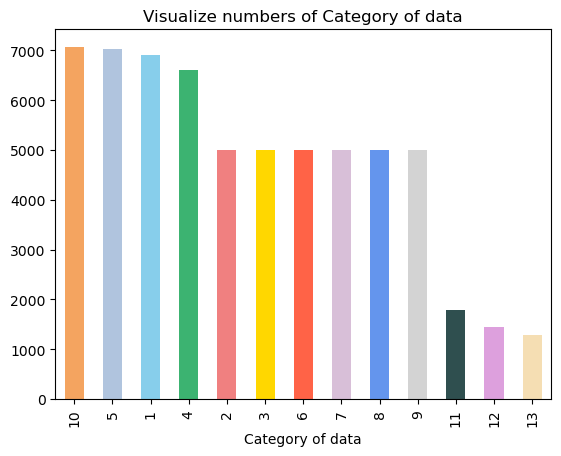

In [81]:
# This is the visualization of final_df dataset to see the total data in each of the categories
category_colors = {
    1: "skyblue",
    2: "lightcoral",
    3: "gold",
    4: "mediumseagreen",
    5: "lightsteelblue",
    6: "tomato",
    7: "thistle",
    8: "cornflowerblue",
    9: "lightgray",
    10: "sandybrown",
    11: "darkslategray",
    12: "plum",
    13: "wheat"

}

# Assuming 'category_id' is the column you want to group by
category_counts = final_df['category_id'].value_counts()

category_counts.plot(kind="bar", color=[category_colors[cat_id] for cat_id in category_counts.index])
plt.xlabel("Category of data")
plt.title("Visualize numbers of Category of data")
plt.show()

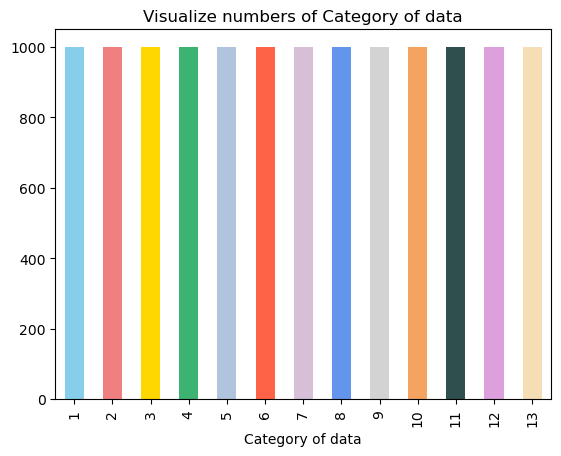

In [82]:
# This is the visualization of selected_data dataset to see the total data in each of the categories
category_colors = {
    1: "skyblue",
    2: "lightcoral",
    3: "gold",
    4: "mediumseagreen",
    5: "lightsteelblue",
    6: "tomato",
    7: "thistle",
    8: "cornflowerblue",
    9: "lightgray",
    10: "sandybrown",
    11: "darkslategray",
    12: "plum",
    13: "wheat"

}

# Assuming 'category_id' is the column you want to group by
category_counts = selected_data['category_id'].value_counts()

category_counts.plot(kind="bar", color=[category_colors[cat_id] for cat_id in category_counts.index])
plt.xlabel("Category of data")
plt.title("Visualize numbers of Category of data")
plt.show()

In [83]:
# We using wordcloud to visualize the most used words in each of the categories.

from wordcloud import WordCloud

stop = set(stopwords.words('english'))

sports = final_df[final_df['category_id'] == 1]

sports = sports['description']

business = final_df[final_df['category_id'] == 2]

business = business['description']

wellness = final_df[final_df['category_id'] == 3]

wellness = wellness['description']

politics = final_df[final_df['category_id'] == 4]

politics = politics['description']

entertainment = final_df[final_df['category_id'] == 5]

entertainment = entertainment['description']

travel = final_df[final_df['category_id'] == 6]

travel = travel['description']

styleandbeauty = final_df[final_df['category_id'] == 7]

styleandbeauty = styleandbeauty['description']

parenting = final_df[final_df['category_id'] == 8]

parenting = parenting['description']

foodanddrink = final_df[final_df['category_id'] == 9]

foodanddrink = foodanddrink['description']

world = final_df[final_df['category_id'] == 10]

world = world['description']

technology = final_df[final_df['category_id'] == 11]

technology = technology['description']

science = final_df[final_df['category_id'] == 12]

science = science['description']

automobile = final_df[final_df['category_id'] == 13]

automobile = automobile['description']

In [84]:
# this is the function for later use to display the wordcloud of most used words in each category

def wordcloud_draw(dataset, color = 'white'):

    words = ' '.join(dataset)

    cleaned_word = ' '.join([word for word in words.split()

    if (word != 'news' and word != 'short_description')])

    wordcloud = WordCloud(stopwords = stop,

    background_color = color,

    width = 2500, height = 2500).generate(cleaned_word)
        

    plt.figure(1, figsize = (10,7))

    plt.imshow(wordcloud)

    plt.axis("off")

    plt.show()

sport related words:


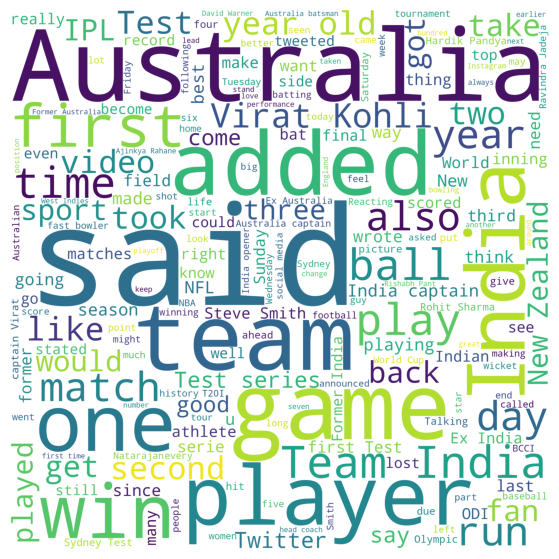

business related words:


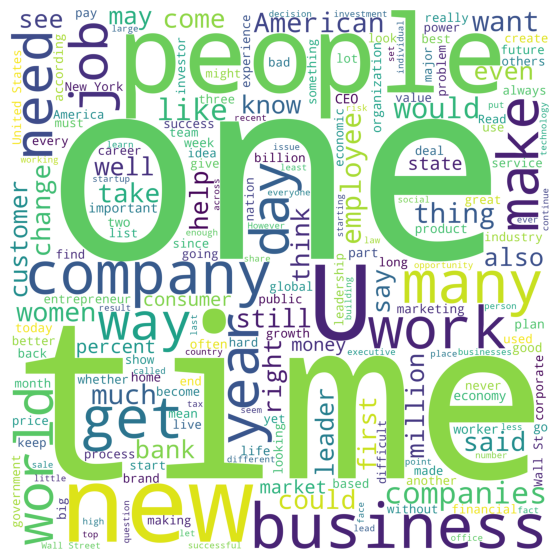

wellness related words:


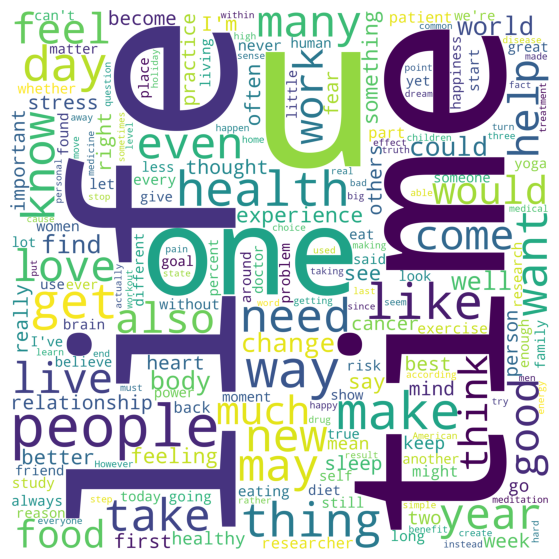

entertainment related words:


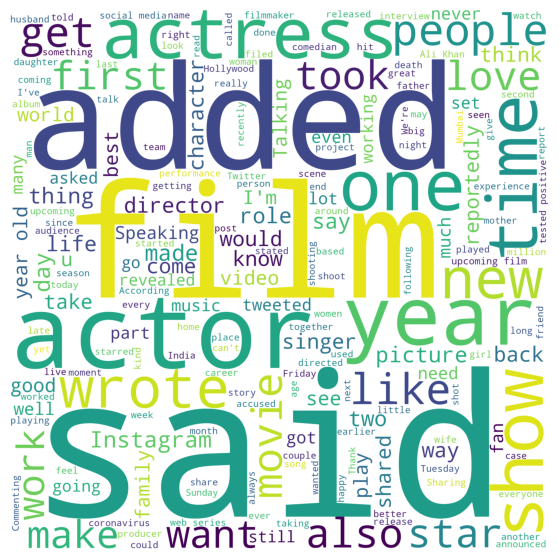

travel related words:


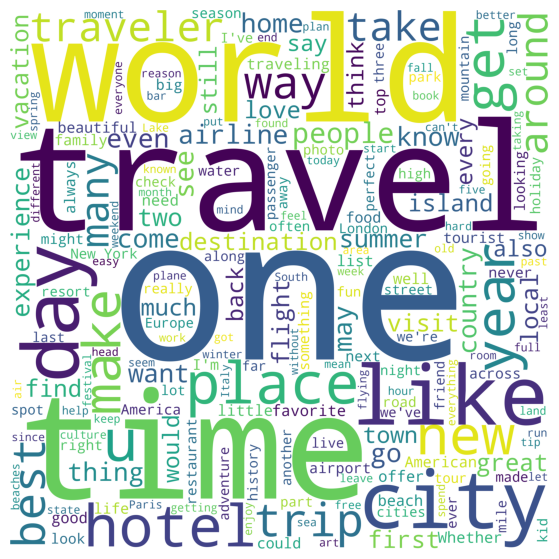

style and beauty related words:


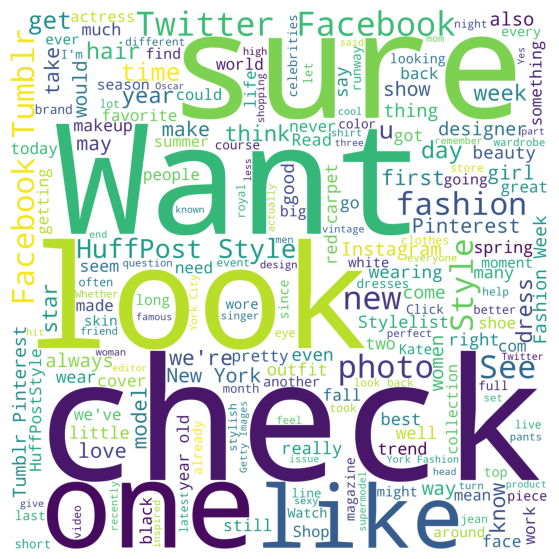

parenting related words:


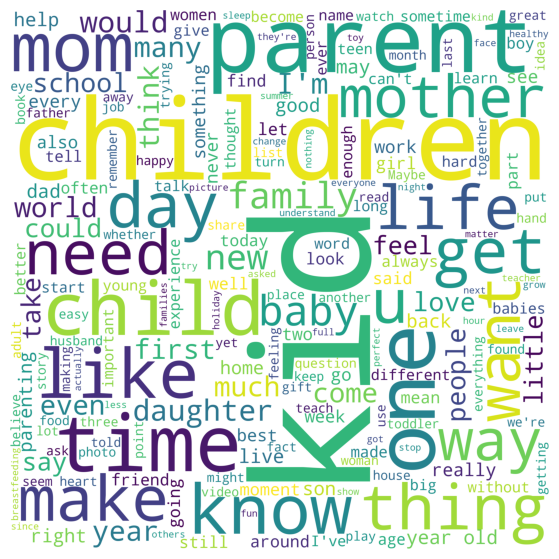

food and drink related words:


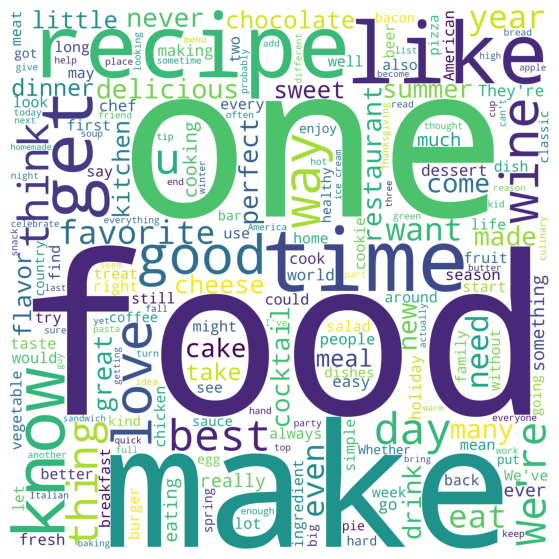

world related words:


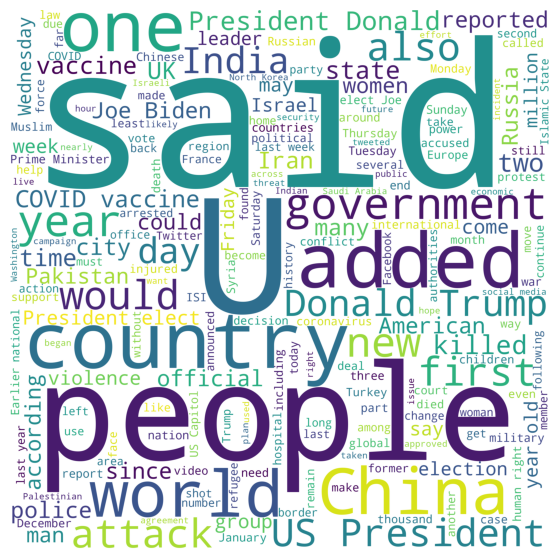

technology related words:


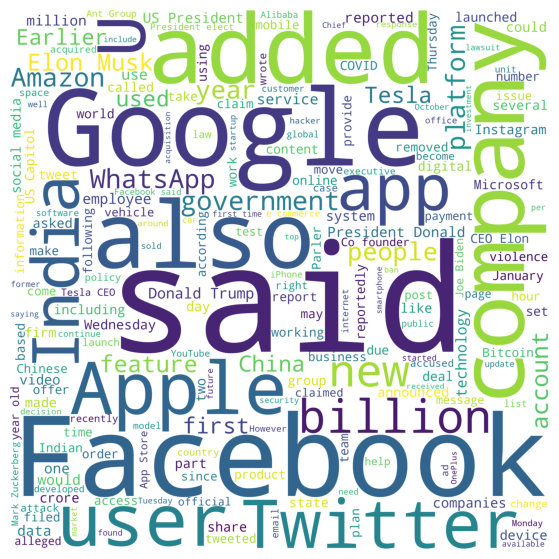

science related words:


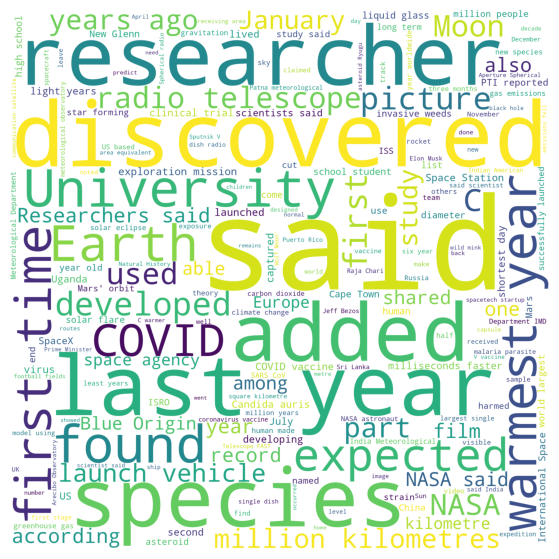

automobile related words:


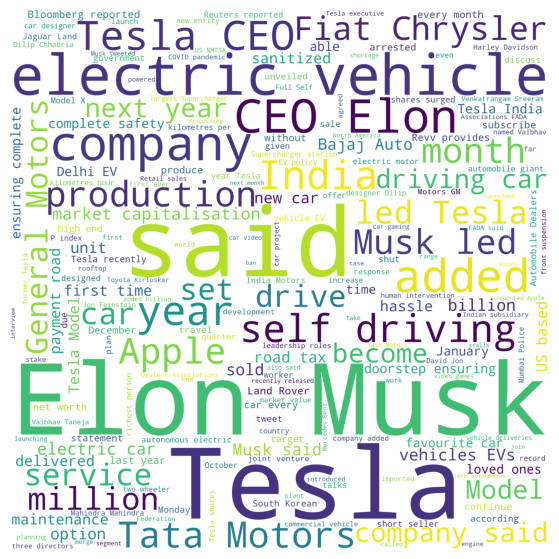

In [85]:
# this is where we display each of the categories with their respective wordclouds

print("sport related words:")

wordcloud_draw(sports, 'white')

print("business related words:")

wordcloud_draw(business, 'white')

print("wellness related words:")

wordcloud_draw(wellness, 'white')

print("entertainment related words:")

wordcloud_draw(entertainment, 'white')

print("travel related words:")

wordcloud_draw(travel, 'white')

print("style and beauty related words:")

wordcloud_draw(styleandbeauty, 'white')

print("parenting related words:")

wordcloud_draw(parenting, 'white')

print("food and drink related words:")

wordcloud_draw(foodanddrink, 'white')

print("world related words:")

wordcloud_draw(world, 'white')

print("technology related words:")

wordcloud_draw(technology, 'white')

print("science related words:")

wordcloud_draw(science, 'white')

print("automobile related words:")

wordcloud_draw(automobile, 'white')

In [86]:
#Remove Tags

def remove_tags(text):
  remove = re.compile(r'<.*?>')
  return re.sub(remove, '', text)

In [87]:
#Special Character removal

def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews

In [88]:
#Lowercasing

def convert_lower(text):
   return text.lower()

In [89]:
#Stopwords removal

def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [x for x in words if x not in stop_words]

In [90]:
#Lemmatization

def lemmatize_word(text):
  wordnet = WordNetLemmatizer()
  return " ".join([wordnet.lemmatize(word) for word in text])

In [91]:
# we did the preprocessing above in final_df dataset

final_df['description'] = final_df['description'].apply(remove_tags)
final_df['description'] = final_df['description'].apply(special_char)
final_df['description'] = final_df['description'].apply(convert_lower)
final_df['description'] = final_df['description'].apply(remove_stopwords)
final_df['description'] = final_df['description'].apply(lemmatize_word)
print(final_df['description'][0])

resting part training confirmed sort already knew built running streak built hard workout three five day week lot cross training physical therapy foam rolling also confirmed stubborn


In [92]:
# we did the preprocessing above in selected_data dataset

selected_data['description'] = selected_data['description'].apply(remove_tags)
selected_data['description'] = selected_data['description'].apply(special_char)
selected_data['description'] = selected_data['description'].apply(convert_lower)
selected_data['description'] = selected_data['description'].apply(remove_stopwords)
selected_data['description'] = selected_data['description'].apply(lemmatize_word)

print(selected_data['description'][0])

indian troop killed four gunman least two indian soldier also killed


### Using final_df dataset with TF-IDF Vectorizer

In [93]:
#Set the Input features and target

x = final_df['description']
y = final_df['category_id']

In [94]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Assuming 'final_df' contains your dataset

x = np.array(final_df.iloc[:,0].values)
y = np.array(final_df.category_id.values)

# Create a TF-IDF vectorizer with a maximum of 6000 features
tfidf = TfidfVectorizer(max_features=7000)

# Transform the text data using TF-IDF vectorization
x = tfidf.fit_transform(final_df.description).toarray()

print("x.shape =", x.shape)
print("y.shape =", y.shape)

x.shape = (62120, 7000)
y.shape = (62120,)


In [95]:
#Split the data into train and test

#TF-IDF
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, shuffle = True)
print(len(x_train))
print(len(x_test))

49696
12424


## Modelling

we did several models to see which one is the best, and then we will conduct hyperparameter tuning for the best model to see how much can we improve from the benchmark

### Decision Tree Classifier

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create and fit the Decision Tree classifier
mdl1 = DecisionTreeClassifier(random_state=42)
mdl1.fit(x_train, y_train)

# Make predictions
y_pred = mdl1.predict(x_test)

# Calculate performance metrics
accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1score = f1_score(y_test, y_pred, average='micro')

print(f'Test Accuracy Score of Decision Tree Classifier: % {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1score}')


Test Accuracy Score of Decision Tree Classifier: % 60.17
Precision: 0.6016580811332904
Recall: 0.6016580811332904
F1-score: 0.6016580811332904


### Multinomial Naive Bayes

In [97]:
from sklearn.naive_bayes import MultinomialNB

# Create and fit the Multinomial Naive Bayes classifier
mdl2 = MultinomialNB()
mdl2.fit(x_train, y_train)

# Make predictions
y_pred = mdl2.predict(x_test)

# Performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1score = f1_score(y_test, y_pred, average='micro')

print(f'Test Accuracy Score of Multinomial Naive Bayes: % {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1score}')


Test Accuracy Score of Multinomial Naive Bayes: % 68.63
Precision: 0.6863329040566645
Recall: 0.6863329040566645
F1-score: 0.6863329040566645


### Logistic Resgression

In [98]:
from sklearn.linear_model import LogisticRegression

# Create and fit the Logistic Regression classifier
mdl3 = LogisticRegression(random_state=42)
mdl3.fit(x_train, y_train)

# Make predictions
y_pred = mdl3.predict(x_test)

# Performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1score = f1_score(y_test, y_pred, average='micro')

print(f'Test Accuracy Score of Logistic Regression: % {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1score}')


/Users/HP/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy Score of Logistic Regression: % 69.95
Precision: 0.6994526722472634
Recall: 0.6994526722472634
F1-score: 0.6994526722472634


### Random Forest Classifier

In [101]:
# Create and fit the Random Forest classifier

mdl = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
mdl.fit(x_train, y_train)

# Make predictions
y_pred = mdl.predict(x_test)

# Performance metrics
accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

# Get precision, recall, and F1-score
precision, recall, f1score, support = score(y_test, y_pred, average='micro')

print(f'Test Accuracy Score of Random Forest: % {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1score}')

Test Accuracy Score of Random Forest: % 66.59
Precision: 0.6658886027044431
Recall: 0.6658886027044431
F1-score: 0.6658886027044431


## Hyperparameter tuning for Logistic Regression
we tune the logistic regression model since it has the most accuracy from all of the other models and also due to it less prone to overfitting

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

# Perform Grid Search for hyperparameter tuning
grid_search = GridSearchCV(mdl3, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Make predictions using the best estimator
y_pred = best_estimator.predict(x_test)

# Calculate performance metrics
accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1score = f1_score(y_test, y_pred, average='micro')

# Print the results
print(f'Best Parameters: {best_params}')
print(f'Test Accuracy Score of Logistic Regression after Hyperparameter Tuning: % {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1score}')


/Users/HP/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/HP/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/Users/HP/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Test Accuracy Score of Logistic Regression after Hyperparameter Tuning: % 69.95
Precision: 0.6994526722472634
Recall: 0.6994526722472634
F1-score: 0.6994526722472634


## Predictions - final_df

In [105]:
# provide input text and preprocess the text

prediction_texts = """PETALING JAYA: Professional men's singles shuttler Lee Zii Jia defeated fellow Malaysian Ng Tze Yong to make it into the second round of the China Masters.

World No. 11 Zii Jia had to dig deep before overcoming world No. 15 Tze Yong 21-15, 20-22, 21-17 in a thrilling opening round match at the Shenzhen Bay Gymnasium on Wednesday (Nov 22).

Zii Jia will next face world No. 16 homester Lu Guangzu in the second round on Thursday (Nov 23).

Meanwhile, women's doubles pair Pearly Tan-M. Thinaah and mixed doubles combinations Goh Soon Huat-Shevon Lai Jemie and Tan Kian Mei-Lai Pei Jing all crashed out of the competition.

World No. 12 Pearly-Thinaah fought hard but agonisingly lost 11-21, 21-15, 20-22 to South Korea's world No. 11 Jeong Na-eun-Kim Hye-jeong.

Soon Huat-Shevon went down 17-21, 20-22 to Hong Kong's Tang Chun Man-Tse Ying Suet, while Kian Meng-Pei Jing fell 16-21, 21-23 to Singapore's Terry Hee-Jessica Tan.””"""

prediction_texts = remove_tags(prediction_texts)
prediction_texts = special_char(prediction_texts)
prediction_texts = convert_lower(prediction_texts)
prediction_texts = remove_stopwords(prediction_texts)
prediction_texts = lemmatize_word(prediction_texts)

print(prediction_texts)

petaling jaya professional men single shuttler lee zii jia defeated fellow malaysian ng tze yong make second round china master world 11 zii jia dig deep overcoming world 15 tze yong 21 15 20 22 21 17 thrilling opening round match shenzhen bay gymnasium wednesday nov 22 zii jia next face world 16 homester lu guangzu second round thursday nov 23 meanwhile woman double pair pearly tan thinaah mixed double combination goh soon huat shevon lai jemie tan kian mei lai pei jing crashed competition world 12 pearly thinaah fought hard agonisingly lost 11 21 21 15 20 22 south korea world 11 jeong na eun kim hye jeong soon huat shevon went 17 21 20 22 hong kong tang chun man tse ying suet kian meng pei jing fell 16 21 21 23 singapore terry hee jessica tan


In [106]:
#Predict the input text

y_pred1 = tfidf.transform([prediction_texts])


yy = best_estimator.predict(y_pred1)
result = ""
if yy == [1]:
  result = "Sports News"
elif yy == [2]:
  result = "Business News"
elif yy == [3]:
  result = "Wellness News"
elif yy == [4]:
  result = "Politics News"
elif yy == [5]:
  result = "Entertainment News"
elif yy == [6]:
  result = "Travel News"
elif yy == [7]:
  result = "Style and Beauty News"
elif yy == [8]:
  result = "Parenting News"
elif yy == [9]:
  result = "Food and Drink News"
elif yy == [10]:
  result = "World News"
elif yy == [11]:
  result = "Technology News"
elif yy == [12]:
  result = "Science News"
elif yy == [13]:
  result = "Automobile News"
print(result)


Sports News


## Using selected_data as the with CountVectorizer

In [107]:
# This is the data that we have created in the earlier lines that only select 1000 rows from each category
selected_data

category                                        description  \
2998       SPORTS                            type sad making mistake   
2339       SPORTS  first time san francisco 49ers quarterback pla...   
2338       SPORTS  scroll update 68 team announced ncaa tournamen...   
2337       SPORTS      league pressure respond swiftly appropriately   
2336       SPORTS  time los angeles influence asian american part...   
...           ...                                                ...   
12338  AUTOMOBILE  baidu become first receive permit beijing tran...   
12339  AUTOMOBILE  road transport highway minister nitin gadkari ...   
12340  AUTOMOBILE  tesla ceo elon musk sent email worker encourag...   
12327  AUTOMOBILE  volkswagen ceo herbert dy blog post revealed o...   
12999  AUTOMOBILE  tesla marked entry india registered company be...   

       category_id  
2998             1  
2339             1  
2338             1  
2337             1  
2336             1  
...            ...  
12338           13  
12339           13  
12340           13  
12327           13  
12999           13  

[13000 rows x 3 columns]

In [108]:
#Set the Input features and target

X = selected_data['description']
Y = selected_data['category_id']

In [109]:
# We also want to try Count vectorizer to see if it is better or worse than TF-IDF
#Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

x = np.array(selected_data.iloc[:,0].values)
y = np.array(selected_data.category_id.values)

cv = CountVectorizer(max_features = 7000)
x = cv.fit_transform(selected_data.description).toarray()

print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (13000, 7000)
y.shape =  (13000,)


In [111]:
# we use joblib to save the vectorizer
from joblib import dump

dump(cv, 'count_vectorizer.joblib')

['count_vectorizer.joblib']

In [112]:
#Split the data into train and test using train test split

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, shuffle = True)
print(len(x_train))
print(len(x_test))

10400
2600


### Decision Tree Classifier

In [113]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create and fit the Decision Tree classifier
mdl1 = DecisionTreeClassifier(random_state=42)
mdl1.fit(x_train, y_train)

# Make predictions
y_pred = mdl1.predict(x_test)

# Calculate performance metrics
accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1score = f1_score(y_test, y_pred, average='micro')

print(f'Test Accuracy Score of Decision Tree Classifier: % {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1score}')


Test Accuracy Score of Decision Tree Classifier: % 57.46
Precision: 0.5746153846153846
Recall: 0.5746153846153846
F1-score: 0.5746153846153846


### MultinomialNB 

In [114]:
from sklearn.naive_bayes import MultinomialNB

# Create and fit the Multinomial Naive Bayes classifier
mdl2 = MultinomialNB()
mdl2.fit(x_train, y_train)

# Make predictions
y_pred = mdl2.predict(x_test)

# Performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1score = f1_score(y_test, y_pred, average='micro')

print(f'Test Accuracy Score of Multinomial Naive Bayes: % {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1score}')


Test Accuracy Score of Multinomial Naive Bayes: % 65.88
Precision: 0.6588461538461539
Recall: 0.6588461538461539
F1-score: 0.6588461538461539


### Logistic Regression

In [115]:
from sklearn.linear_model import LogisticRegression

# Create and fit the Logistic Regression classifier
mdl5 = LogisticRegression(random_state=42)
mdl5.fit(x_train, y_train)

# Make predictions
y_pred = mdl5.predict(x_test)

# Performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1score = f1_score(y_test, y_pred, average='micro')

print(f'Test Accuracy Score of Logistic Regression: % {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1score}')


Test Accuracy Score of Logistic Regression: % 68.08
Precision: 0.6807692307692308
Recall: 0.6807692307692308
F1-score: 0.6807692307692308


/Users/HP/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest Classifier

In [116]:
# Create and fit the Random Forest classifier

mdl = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=42)
mdl.fit(x_train, y_train)

# Make predictions
y_pred = mdl.predict(x_test)

# Performance metrics
accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

# Get precision, recall, and F1-score
precision, recall, f1score, support = score(y_test, y_pred, average='micro')

print(f'Test Accuracy Score of Random Forest: % {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1score}')

Test Accuracy Score of Random Forest: % 59.88
Precision: 0.5988461538461538
Recall: 0.5988461538461538
F1-score: 0.5988461538461538


## Hyperparameter Tuning for Logistic Regression
the reason we choose Logistic regression is the same as above.

In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the hyperparameters and their possible values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

# Perform Grid Search for hyperparameter tuning
grid_search = GridSearchCV(mdl5, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimatorss = grid_search.best_estimator_

# Make predictions using the best estimator
y_pred = best_estimatorss.predict(x_test)

# Calculate performance metrics
accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1score = f1_score(y_test, y_pred, average='micro')

# Print the results
print(f'Best Parameters: {best_params}')
print(f'Test Accuracy Score of Logistic Regression after Hyperparameter Tuning: % {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1score}')


/Users/HP/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/HP/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy Score of Logistic Regression after Hyperparameter Tuning: % 68.5
Precision: 0.685
Recall: 0.685
F1-score: 0.685


In [118]:
from joblib import dump

# Save the model for deployment later on
dump(best_estimatorss, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

## Predictions - selected_data

In [119]:
# provide input texts and preprocess the text
prediction_texts = """“MANCHESTER, England (Reuters) - Manchester United defender Luke Shaw has returned to training after being sidelined for three months with a muscle injury, the club said on Wednesday.

The England left back suffered the injury in August after appearing in United's first two Premier League games of the season.

Erik ten Hag's team have several injury concerns ahead of Sunday's league game at Everton. Christian Eriksen (knee) and Rasmus Hojlund (thigh) withdrew from the Denmark squad last week and goalkeeper Andre Onana was hurt playing for Cameroon.

”"""

prediction_texts = remove_tags(prediction_texts)
prediction_texts = special_char(prediction_texts)
prediction_texts = convert_lower(prediction_texts)
prediction_texts = remove_stopwords(prediction_texts)
prediction_texts = lemmatize_word(prediction_texts)

print(prediction_texts)

manchester england reuters manchester united defender luke shaw returned training sidelined three month muscle injury club said wednesday england left back suffered injury august appearing united first two premier league game season erik ten hag team several injury concern ahead sunday league game everton christian eriksen knee rasmus hojlund thigh withdrew denmark squad last week goalkeeper andre onana hurt playing cameroon


In [120]:
#Predict the input text

y_pred1 = cv.transform([prediction_texts])


yy = best_estimatorss.predict(y_pred1)
result = ""
if yy == [1]:
  result = "Sports News"
elif yy == [2]:
  result = "Business News"
elif yy == [3]:
  result = "Wellness News"
elif yy == [4]:
  result = "Politics News"
elif yy == [5]:
  result = "Entertainment News"
elif yy == [6]:
  result = "Travel News"
elif yy == [7]:
  result = "Style and Beauty News"
elif yy == [8]:
  result = "Parenting News"
elif yy == [9]:
  result = "Food and Drink News"
elif yy == [10]:
  result = "World News"
elif yy == [11]:
  result = "Technology News"
elif yy == [12]:
  result = "Science News"
elif yy == [13]:
  result = "Automobile News"
print(result)


Sports News


# Results and Discussion
==========================================

## LSTM

According to (Karmakar et al., 2021), Attention LSTM require longer time to train, but it has the perks of having low training and testing loss, but for stacked LSTM, it has low training duration but accuracy is not as good. Thus, these results are also similar in our research where the LSTM without attention has higher training and validation loss, but LSTM with attention mechanism has a lower traing loss, but validation loss only has a slight difference from the normal LSTM. Thus resulting in the model learning too well in training phase but if fails to accurately predict summarization in new data. According to my research, these issue is likely caused by the lack of proper dataset to train and machine inability to support the training process, therefore reducing the quality of the model even after including attention in it.

## Fine Tuned Pegasus

In terms of the results, eventhough we have fine-tune the pegasus model with our own dataset, it still predicts the output in a extractive manner in some cases, but the changes or improvements the model can make is only in terms of the sentence structure, or changes in pronouns from names, but in the end it still more toward to the extractive part. 

## T5, BART, PEGASUS

From the results above, we can deduce that T5 is mostly extractive, since it extracts the most important sentences from the input text or sample text and generate summarization based on sentences extracted. On the other hand, even though BART and PEGASUS generates summaries that is similar to T5 but these models will generate more natural setence structure, and also alter some of the word such as if the text mention "Mario", they can use the word "he" in the next sentences if there is Mario in it.

## News Identification

According to (Hussain et al., 2023), SVM has a higher accuracy which is around 84% and Logistic regression is the second with 81% accuracy in their reseach of Bangla news article classification. But as we can see in the news identification, logistic regression is the best option within the four model, and the other three models are DecisionTreeClassifier, MultinomialNB, RandomForestClassifier. 

Moreover, we discover that using selected_data is more accurate then using the original data, and same goes to using countVectorizer rather then TF-IDF Vectorizer. The reason we can conclude in why selected_data is better is due to the balance dataset, where in the final_df data there are several large data in various category but there are some low data categories, for instance, technology, science, and automobile. As a result, the model will tend to understand more in other categories thus lead to lower accuracy. 

Note: Due to the change in the accuracy when combining all the codes for text summarization and identification together, i will also provide the news identification.ipynb inside the folder to show the actual accuracy.

### References:

Hussain, M. G., Sultana, B., Rahman, M., &amp; Hasan, M. R. (2023). Comparison analysis of Bangla news articles classification using support Vector Machine and logistic regression. TELKOMNIKA (Telecommunication Computing Electronics and Control), 21(3), 584. https://doi.org/10.12928/telkomnika.v21i3.23416 

Karmakar, R., Nirantar, K., Kurunkar, P., Hiremath, P., &amp; Chaudhari, D. (2021). Indian regional language abstractive text summarization using attention-based LSTM neural network. 2021 International Conference on Intelligent Technologies (CONIT). https://doi.org/10.1109/conit51480.2021.9498309 

# Challenges Faced
==========================================

There are several challenges we faced throughout the whole process. Thus, we will dicuss these challeges below.

Firstly is LSTM, since we do not have a proper machine to support the training process of the model, we end up with a low quality dataset. Moreover, the attention mechanism is also difficult to find, since orginially it should have a library to straight utlilize the attention layer, but it is unusable in the assignment, thats why we created the whole attention layer class and integrate it into the LSTM model. Although the result is better when training, but when provided random text input, it predicts poorly.

In terms of the news identification, we also have a difficulty in increasing the accuracy of the model selected when using the original dataset, so we did experiments in various areas and ended up with creating a balanced data to use it in the modelling and it provide a 10% improvement in the accuracy.

Lastly, before development, we tend to try incorporating using a random input text to test the model accuracy, but different models required different ways in using the model to predict the summaries, especially LSTM prediction. Hence, we also waste alot of time in figuring out how to use random input to predict the summaries.

# Future Improvements
==========================================

In regards of fure improvements, there is alot to consider. Thus we will discuss those improvements below.

First and foremost, using different models in the abstractive text summarization, since we are using LSTM, we can try using Bi-directional LSTM or Pointer - LSTM to see if the accuracy will be better. But we also need to consider if the machine can support these models. Thus, hardware improvement is also needed to boost the training process of the model so that it can handle bigger datasets which translates to having a more accurate model later on.

In terms of News identification, we can also try using other models such as SVC, KNN, GaussianNB, to see if these models perform better then the existing models used. Moreover, we can also find more datasets for the imbalanced categories to see if more data can provide a even more accurate model.